# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 13            
model_seed = 3           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import Fashion_MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.3380 | Test Loss 2.1519 | accs Train 0.0167 Test 0.4303


Epoch 100/2000: Train Loss 0.0003 | Test Loss 2.0094 | accs Train 1.0000 Test 0.6732


Epoch 200/2000: Train Loss 0.0001 | Test Loss 2.0874 | accs Train 1.0000 Test 0.6740


Epoch 300/2000: Train Loss 0.0001 | Test Loss 2.1552 | accs Train 1.0000 Test 0.6739


Epoch 400/2000: Train Loss 0.0001 | Test Loss 2.2090 | accs Train 1.0000 Test 0.6736


Epoch 500/2000: Train Loss 0.0000 | Test Loss 2.2509 | accs Train 1.0000 Test 0.6736


Epoch 600/2000: Train Loss 0.0000 | Test Loss 2.2879 | accs Train 1.0000 Test 0.6734


Epoch 700/2000: Train Loss 0.0000 | Test Loss 2.3209 | accs Train 1.0000 Test 0.6731


Epoch 800/2000: Train Loss 0.0000 | Test Loss 2.3557 | accs Train 1.0000 Test 0.6723


Epoch 900/2000: Train Loss 0.0000 | Test Loss 2.3872 | accs Train 1.0000 Test 0.6727


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 2.4181 | accs Train 1.0000 Test 0.6724


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 2.4463 | accs Train 1.0000 Test 0.6721


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 2.4717 | accs Train 1.0000 Test 0.6716


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 2.4951 | accs Train 1.0000 Test 0.6722


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 2.5160 | accs Train 1.0000 Test 0.6721


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 2.5337 | accs Train 1.0000 Test 0.6720


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 2.5491 | accs Train 1.0000 Test 0.6722


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 2.5636 | accs Train 1.0000 Test 0.6717


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 2.5767 | accs Train 1.0000 Test 0.6717


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 2.5890 | accs Train 1.0000 Test 0.6718


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 2.6002 | accs Train 1.0000 Test 0.6725
Completed training with 0 additional samples of data
Epoch 1/2000: Train Loss 2.3179 | Test Loss 2.1231 | accs Train 0.0550 Test 0.4544


Epoch 100/2000: Train Loss 0.0056 | Test Loss 1.1194 | accs Train 1.0000 Test 0.7717


Epoch 200/2000: Train Loss 0.0010 | Test Loss 1.3361 | accs Train 1.0000 Test 0.7732


Epoch 300/2000: Train Loss 0.0004 | Test Loss 1.4469 | accs Train 1.0000 Test 0.7729


Epoch 400/2000: Train Loss 0.0002 | Test Loss 1.5231 | accs Train 1.0000 Test 0.7734


Epoch 500/2000: Train Loss 0.0002 | Test Loss 1.5820 | accs Train 1.0000 Test 0.7732


Epoch 600/2000: Train Loss 0.0001 | Test Loss 1.6291 | accs Train 1.0000 Test 0.7728


Epoch 700/2000: Train Loss 0.0001 | Test Loss 1.6690 | accs Train 1.0000 Test 0.7727


Epoch 800/2000: Train Loss 0.0001 | Test Loss 1.7034 | accs Train 1.0000 Test 0.7724


Epoch 900/2000: Train Loss 0.0001 | Test Loss 1.7337 | accs Train 1.0000 Test 0.7727


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 1.7603 | accs Train 1.0000 Test 0.7725


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 1.7853 | accs Train 1.0000 Test 0.7729


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 1.8081 | accs Train 1.0000 Test 0.7732


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 1.8291 | accs Train 1.0000 Test 0.7735


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 1.8489 | accs Train 1.0000 Test 0.7734


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 1.8672 | accs Train 1.0000 Test 0.7734


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 1.8843 | accs Train 1.0000 Test 0.7735


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 1.9004 | accs Train 1.0000 Test 0.7735


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 1.9155 | accs Train 1.0000 Test 0.7735


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 1.9300 | accs Train 1.0000 Test 0.7733


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 1.9437 | accs Train 1.0000 Test 0.7731
Completed training with 540 additional samples of data
Epoch 1/2000: Train Loss 2.3121 | Test Loss 2.1186 | accs Train 0.0585 Test 0.4401


Epoch 100/2000: Train Loss 0.0513 | Test Loss 0.6896 | accs Train 0.9950 Test 0.8084


Epoch 200/2000: Train Loss 0.0038 | Test Loss 1.0003 | accs Train 1.0000 Test 0.8072


Epoch 300/2000: Train Loss 0.0012 | Test Loss 1.1462 | accs Train 1.0000 Test 0.8067


Epoch 400/2000: Train Loss 0.0006 | Test Loss 1.2439 | accs Train 1.0000 Test 0.8056


Epoch 500/2000: Train Loss 0.0004 | Test Loss 1.3173 | accs Train 1.0000 Test 0.8045


Epoch 600/2000: Train Loss 0.0002 | Test Loss 1.3725 | accs Train 1.0000 Test 0.8043


Epoch 700/2000: Train Loss 0.0002 | Test Loss 1.4174 | accs Train 1.0000 Test 0.8039


Epoch 800/2000: Train Loss 0.0001 | Test Loss 1.4556 | accs Train 1.0000 Test 0.8034


Epoch 900/2000: Train Loss 0.0001 | Test Loss 1.4886 | accs Train 1.0000 Test 0.8032


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 1.5180 | accs Train 1.0000 Test 0.8031


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 1.5449 | accs Train 1.0000 Test 0.8028


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 1.5713 | accs Train 1.0000 Test 0.8029


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 1.5957 | accs Train 1.0000 Test 0.8029


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 1.6174 | accs Train 1.0000 Test 0.8028


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 1.6375 | accs Train 1.0000 Test 0.8026


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 1.6563 | accs Train 1.0000 Test 0.8025


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 1.6741 | accs Train 1.0000 Test 0.8021


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 1.6910 | accs Train 1.0000 Test 0.8021


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 1.7069 | accs Train 1.0000 Test 0.8022


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 1.7221 | accs Train 1.0000 Test 0.8021
Completed training with 1940 additional samples of data
Epoch 1/2000: Train Loss 2.3158 | Test Loss 2.1185 | accs Train 0.0638 Test 0.4554


Epoch 100/2000: Train Loss 0.2268 | Test Loss 0.4521 | accs Train 0.9237 Test 0.8453


Epoch 200/2000: Train Loss 0.0613 | Test Loss 0.5542 | accs Train 0.9890 Test 0.8441


Epoch 300/2000: Train Loss 0.0139 | Test Loss 0.7225 | accs Train 0.9998 Test 0.8414


Epoch 400/2000: Train Loss 0.0045 | Test Loss 0.8660 | accs Train 1.0000 Test 0.8413


Epoch 500/2000: Train Loss 0.0020 | Test Loss 0.9706 | accs Train 1.0000 Test 0.8403


Epoch 600/2000: Train Loss 0.0012 | Test Loss 1.0471 | accs Train 1.0000 Test 0.8399


Epoch 700/2000: Train Loss 0.0007 | Test Loss 1.1066 | accs Train 1.0000 Test 0.8394


Epoch 800/2000: Train Loss 0.0005 | Test Loss 1.1558 | accs Train 1.0000 Test 0.8387


Epoch 900/2000: Train Loss 0.0004 | Test Loss 1.1982 | accs Train 1.0000 Test 0.8385


Epoch 1000/2000: Train Loss 0.0003 | Test Loss 1.2336 | accs Train 1.0000 Test 0.8381


Epoch 1100/2000: Train Loss 0.0002 | Test Loss 1.2653 | accs Train 1.0000 Test 0.8376


Epoch 1200/2000: Train Loss 0.0002 | Test Loss 1.2936 | accs Train 1.0000 Test 0.8378


Epoch 1300/2000: Train Loss 0.0002 | Test Loss 1.3195 | accs Train 1.0000 Test 0.8370


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 1.3434 | accs Train 1.0000 Test 0.8369


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 1.3651 | accs Train 1.0000 Test 0.8367


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 1.3852 | accs Train 1.0000 Test 0.8367


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 1.4041 | accs Train 1.0000 Test 0.8362


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 1.4220 | accs Train 1.0000 Test 0.8366


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 1.4388 | accs Train 1.0000 Test 0.8367


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 1.4548 | accs Train 1.0000 Test 0.8365
Completed training with 5940 additional samples of data
Epoch 1/2000: Train Loss 2.3149 | Test Loss 2.1180 | accs Train 0.0631 Test 0.4546


Epoch 100/2000: Train Loss 0.3070 | Test Loss 0.3976 | accs Train 0.8893 Test 0.8612


Epoch 200/2000: Train Loss 0.1852 | Test Loss 0.3819 | accs Train 0.9365 Test 0.8709


Epoch 300/2000: Train Loss 0.1127 | Test Loss 0.4246 | accs Train 0.9658 Test 0.8672


Epoch 400/2000: Train Loss 0.0706 | Test Loss 0.4992 | accs Train 0.9799 Test 0.8642


Epoch 500/2000: Train Loss 0.0378 | Test Loss 0.5659 | accs Train 0.9941 Test 0.8640


Epoch 600/2000: Train Loss 0.0258 | Test Loss 0.6243 | accs Train 0.9965 Test 0.8643


Epoch 700/2000: Train Loss 0.0166 | Test Loss 0.6819 | accs Train 0.9989 Test 0.8638


Epoch 800/2000: Train Loss 0.0111 | Test Loss 0.7360 | accs Train 0.9995 Test 0.8625


Epoch 900/2000: Train Loss 0.0076 | Test Loss 0.7872 | accs Train 0.9998 Test 0.8623


Epoch 1000/2000: Train Loss 0.0054 | Test Loss 0.8329 | accs Train 0.9999 Test 0.8624


Epoch 1100/2000: Train Loss 0.0039 | Test Loss 0.8732 | accs Train 1.0000 Test 0.8628


Epoch 1200/2000: Train Loss 0.0030 | Test Loss 0.9100 | accs Train 1.0000 Test 0.8624


Epoch 1300/2000: Train Loss 0.0023 | Test Loss 0.9432 | accs Train 1.0000 Test 0.8619


Epoch 1400/2000: Train Loss 0.0018 | Test Loss 0.9737 | accs Train 1.0000 Test 0.8612


Epoch 1500/2000: Train Loss 0.0015 | Test Loss 1.0016 | accs Train 1.0000 Test 0.8609


Epoch 1600/2000: Train Loss 0.0012 | Test Loss 1.0269 | accs Train 1.0000 Test 0.8614


Epoch 1700/2000: Train Loss 0.0010 | Test Loss 1.0504 | accs Train 1.0000 Test 0.8610


Epoch 1800/2000: Train Loss 0.0009 | Test Loss 1.0725 | accs Train 1.0000 Test 0.8611


Epoch 1900/2000: Train Loss 0.0007 | Test Loss 1.0931 | accs Train 1.0000 Test 0.8608


Epoch 2000/2000: Train Loss 0.0006 | Test Loss 1.1122 | accs Train 1.0000 Test 0.8604
Completed training with 19940 additional samples of data
Epoch 1/2000: Train Loss 2.3145 | Test Loss 2.1177 | accs Train 0.0622 Test 0.4619


Epoch 100/2000: Train Loss 0.3392 | Test Loss 0.3869 | accs Train 0.8791 Test 0.8622


Epoch 200/2000: Train Loss 0.2570 | Test Loss 0.3408 | accs Train 0.9069 Test 0.8782


Epoch 300/2000: Train Loss 0.2040 | Test Loss 0.3289 | accs Train 0.9280 Test 0.8853


Epoch 400/2000: Train Loss 0.1695 | Test Loss 0.3390 | accs Train 0.9408 Test 0.8858


Epoch 500/2000: Train Loss 0.1359 | Test Loss 0.3531 | accs Train 0.9541 Test 0.8849


Epoch 600/2000: Train Loss 0.1170 | Test Loss 0.3849 | accs Train 0.9600 Test 0.8819


Epoch 700/2000: Train Loss 0.0986 | Test Loss 0.4100 | accs Train 0.9668 Test 0.8827


Epoch 800/2000: Train Loss 0.0749 | Test Loss 0.4339 | accs Train 0.9783 Test 0.8851


Epoch 900/2000: Train Loss 0.0602 | Test Loss 0.4652 | accs Train 0.9850 Test 0.8829


Epoch 1000/2000: Train Loss 0.0499 | Test Loss 0.4955 | accs Train 0.9882 Test 0.8814


Epoch 1100/2000: Train Loss 0.0409 | Test Loss 0.5278 | accs Train 0.9912 Test 0.8819


Epoch 1200/2000: Train Loss 0.0336 | Test Loss 0.5585 | accs Train 0.9934 Test 0.8815


Epoch 1300/2000: Train Loss 0.0300 | Test Loss 0.5937 | accs Train 0.9933 Test 0.8803


Epoch 1400/2000: Train Loss 0.1978 | Test Loss 0.3876 | accs Train 0.9248 Test 0.8763


Epoch 1500/2000: Train Loss 0.1117 | Test Loss 0.4218 | accs Train 0.9609 Test 0.8785


Epoch 1600/2000: Train Loss 0.0725 | Test Loss 0.4808 | accs Train 0.9779 Test 0.8796


Epoch 1700/2000: Train Loss 0.0531 | Test Loss 0.5351 | accs Train 0.9862 Test 0.8784


Epoch 1800/2000: Train Loss 0.0410 | Test Loss 0.5786 | accs Train 0.9905 Test 0.8785


Epoch 1900/2000: Train Loss 0.0337 | Test Loss 0.6137 | accs Train 0.9932 Test 0.8790


Epoch 2000/2000: Train Loss 0.0270 | Test Loss 0.6420 | accs Train 0.9955 Test 0.8791
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 2.6002 | accs: 0.6725
 540 samples | Test Loss: 1.9437 | accs: 0.7731
1940 samples | Test Loss: 1.7221 | accs: 0.8021
5940 samples | Test Loss: 1.4548 | accs: 0.8365
19940 samples | Test Loss: 1.1122 | accs: 0.8604
59940 samples | Test Loss: 0.6420 | accs: 0.8791

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0014 | accs: 1.0000
 Model 59940 | Train Loss: 0.0336 | accs: 0.9833

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 2.2970 | accs: 0.7117
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0007 | accs: 1.0000
 Model 59940 | Trai

 Model 1940 | Train Loss: 1.5303 | accs: 0.8248


 Model 5940 | Train Loss: 1.1701 | accs: 0.8633
 Model 19940 | Train Loss: 0.6742 | accs: 0.9143
 Model 59940 | Train Loss: 0.0267 | accs: 0.9955


### Model + Data Specific Verification

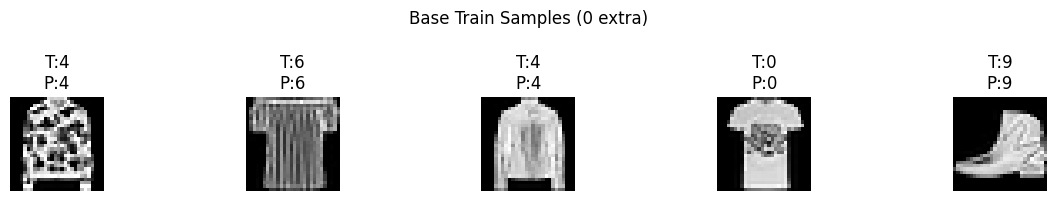

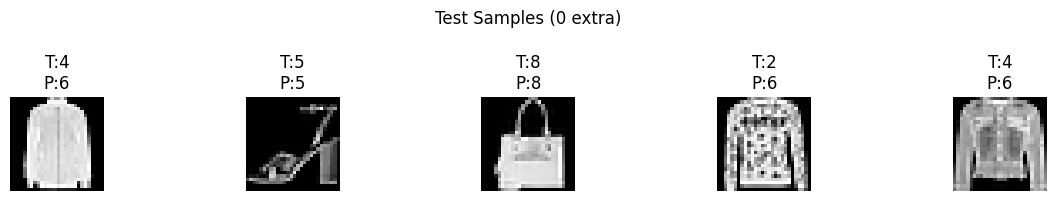

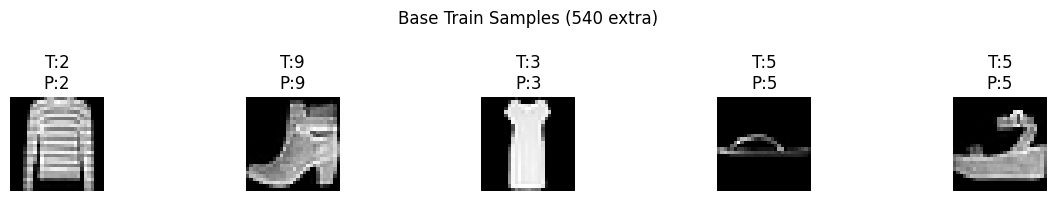

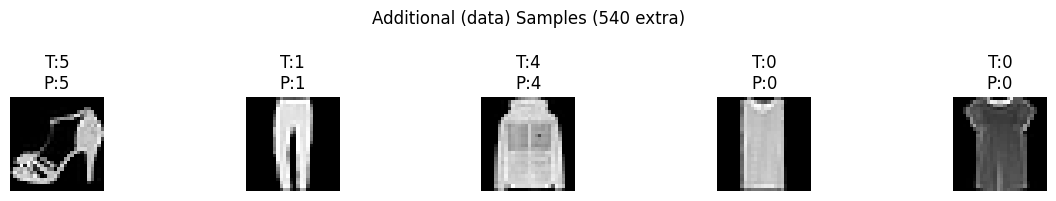

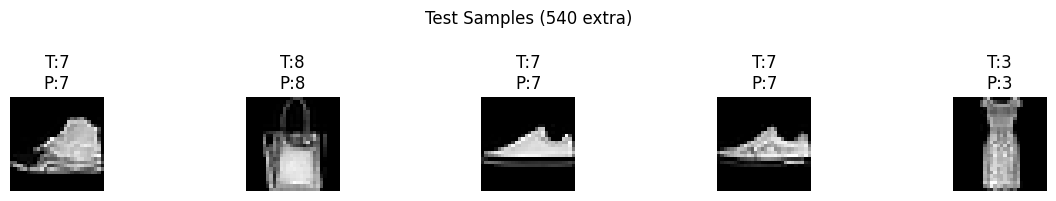

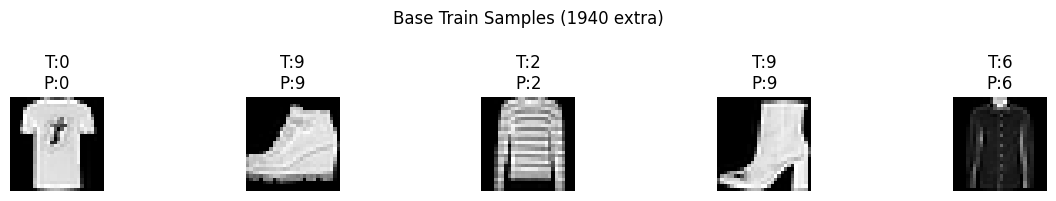

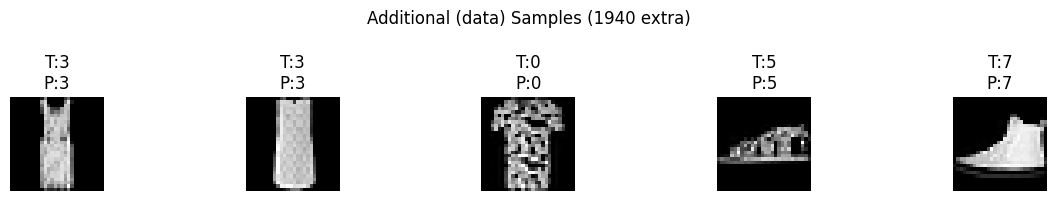

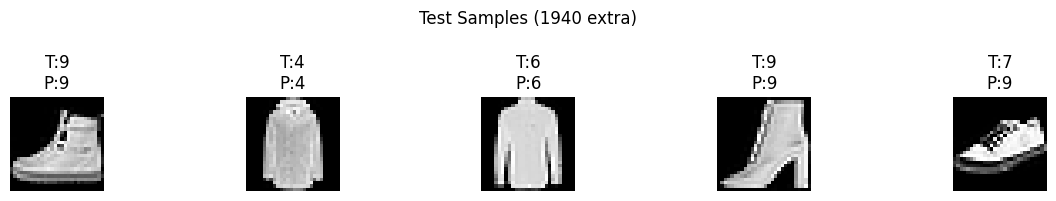

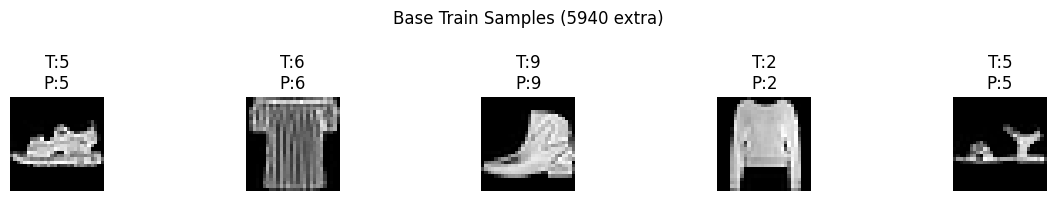

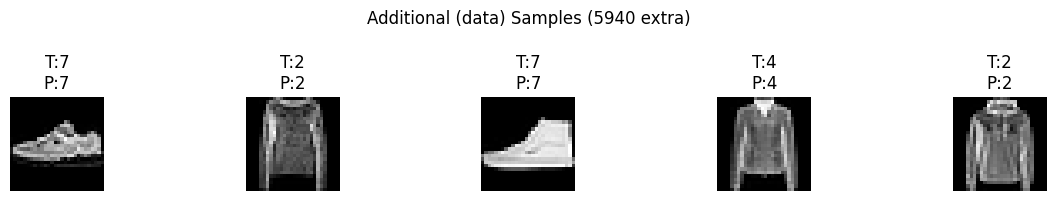

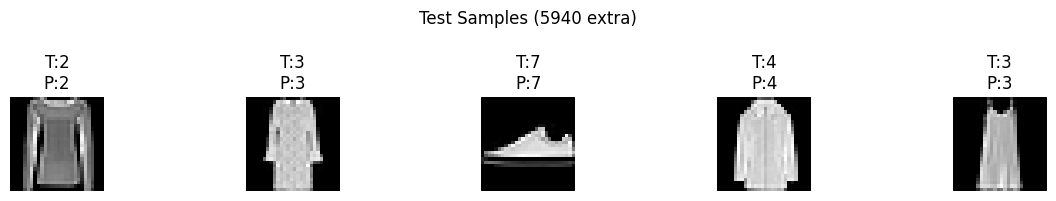

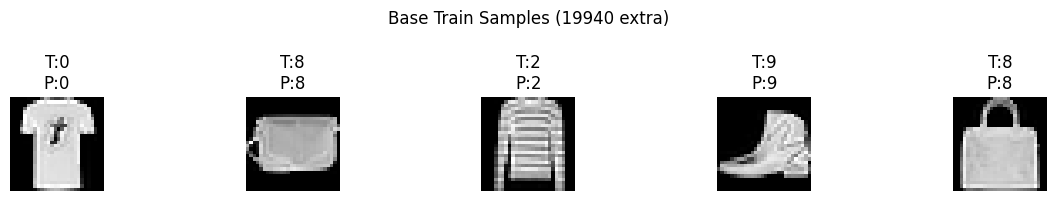

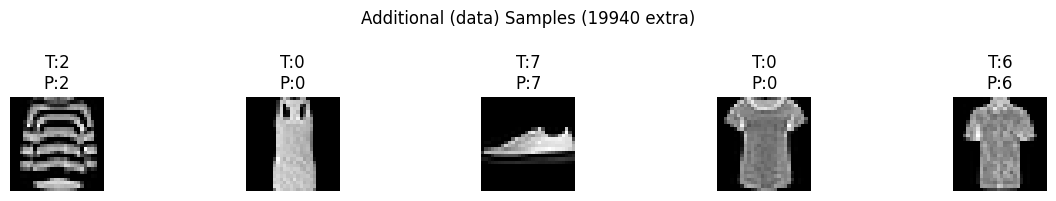

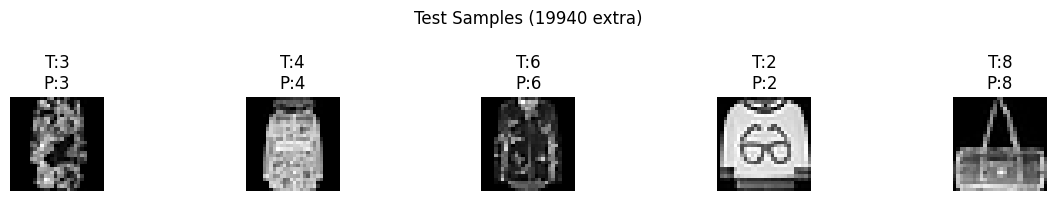

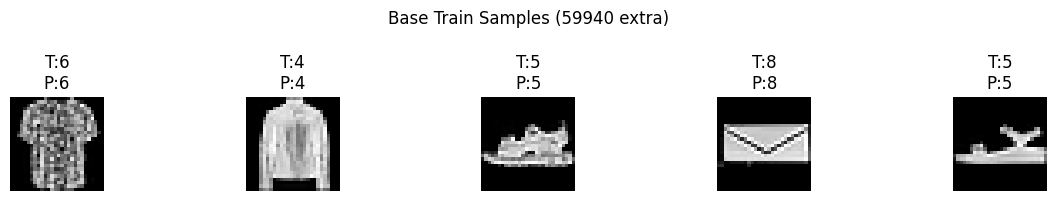

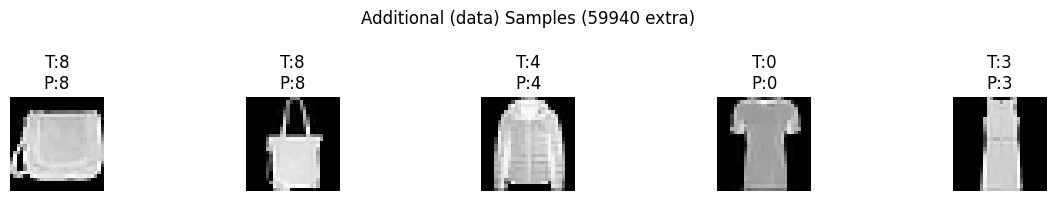

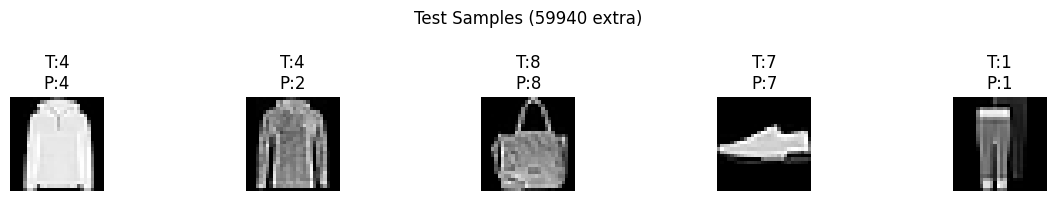

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
